In [1]:
import netCDF4 as nc
import xarray as xr
from geoarray import GeoArray
from spectral.io import envi
import matplotlib.pyplot as plt
import numpy as np
from isofit.core.common import resample_spectrum
import os
import isofit
from isofit.core.sunposition import sunpos
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import holoviews as hv
import hvplot.xarray
from datetime import datetime

C:\Users\vpatro\AppData\Local\anaconda3\envs\isofit_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# NetCDF4

rad_nc = '../../EMIT-scenes/west_africa_scene/EMIT_L1B_RAD_001_20230321T150833_2308010_003.nc'
ds_rad = nc.Dataset(rad_nc)
mask_nc = '../../EMIT-scenes/west_africa_scene/EMIT_L2A_MASK_001_20230321T150833_2308010_003.nc'
ds_mask = nc.Dataset(mask_nc)

# envi for non orthorectified
rad_header = envi.open('../../EMIT-scenes/west_africa_scene/EMIT_L1B_RAD_001_20230321T150833_2308010_003_radiance.hdr')
print(type(rad_header))
#print(ds.metadata)
dat_rad = rad_header.open_memmap(interleave='bip')
print(dat_rad.shape)


# no need for ortho
# information will be in another file


<class 'spectral.io.bilfile.BilFile'>
(1280, 1242, 285)


C:\Users\vpatro\AppData\Local\anaconda3\envs\isofit_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [7]:
wl = rad_header.metadata['wavelength']
for i in range(len(wl)):
    wl[i] = float(wl[i])
wl = np.array(wl)

fwhm = rad_header.metadata['fwhm']
for i in range(len(fwhm)):
    fwhm[i] = float(fwhm[i])
fwhm = np.array(fwhm)

print(type(wl))
print(type(wl[1]))
wl[0]

<class 'numpy.ndarray'>
<class 'numpy.float64'>


381.00558

In [8]:
# will need new irradiance file
irr_file = os.path.join(
    os.path.dirname(isofit.__file__), "..", "data", "kurudz_0.1nm.dat") # same for anything TOA, pure solar irradiance

print(os.path.dirname(isofit.__file__))
print(irr_file)


irr_wl, irr = np.loadtxt(irr_file, comments="#").T
irr = irr / 10  # convert to uW cm-2 sr-1 nm-1
irr_resamp = resample_spectrum(irr, irr_wl, wl, fwhm)
irr_resamp = np.array(irr_resamp, dtype=np.float32)
irr = irr_resamp

print(type(irr))

C:\Users\vpatro\Desktop\isofit\isofit
C:\Users\vpatro\Desktop\isofit\isofit\..\data\kurudz_0.1nm.dat
<class 'numpy.ndarray'>


In [9]:
rad_array = xr.open_dataset('../../EMIT-scenes/west_africa_scene/EMIT_L1B_RAD_001_20230321T150833_2308010_003.nc')
rad_array

<xarray.Dataset>
Dimensions:   (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    radiance  (downtrack, crosstrack, bands) float32 ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             5.385671869588819
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 3.55428331e-01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L1B At-Sensor Calibrated Radiance...

In [10]:
wvl = xr.open_dataset(rad_nc,group='sensor_band_parameters')
wvl

<xarray.Dataset>
Dimensions:      (bands: 285)
Dimensions without coordinates: bands
Data variables:
    wavelengths  (bands) float32 ...
    fwhm         (bands) float32 ...

In [11]:
wl_netcdf = wvl['wavelengths'].data
fwhm_netcdf = wvl['fwhm'].data

In [12]:
loc = xr.open_dataset(rad_nc,group='location')
loc

<xarray.Dataset>
Dimensions:  (downtrack: 1280, crosstrack: 1242, ortho_y: 1888, ortho_x: 1912)
Dimensions without coordinates: downtrack, crosstrack, ortho_y, ortho_x
Data variables:
    lon      (downtrack, crosstrack) float64 ...
    lat      (downtrack, crosstrack) float64 ...
    elev     (downtrack, crosstrack) float64 ...
    glt_x    (ortho_y, ortho_x) float64 ...
    glt_y    (ortho_y, ortho_x) float64 ...

In [13]:
lon = loc['lon'].data
lat = loc['lat'].data
elev = loc['elev'].data
print(lat.shape)
print(lon.shape)
print(elev.shape)
dt = datetime(2023, 3, 21, 15, 8, 33, 0000) # strftime and strptime (string to dt conversions and vice versa)
dt

(1280, 1242)
(1280, 1242)
(1280, 1242)


datetime.datetime(2023, 3, 21, 15, 8, 33)

In [14]:
zen = np.arange(1589760).reshape(1280,1242)
zen = zen.astype(object)
type(zen)

numpy.ndarray

In [15]:
# above calculation taking a while to run

In [16]:
import time

# just using a random zenith angle as the angle for the entire scene
start = time.time()
zen = sunpos(dt, lat[750][750], lon[750][750], elev[750][750], radians = True)
end = time.time()
elapsed = end-start
print(str(elapsed) + ' seconds')

0.020774126052856445 seconds


In [13]:
# for loops call from Python to C and corresponding overhead is expensive
# would like to do everything natively in Python
# broadcasting - Python performs matrix operations in N - dimensions

In [17]:
dat_rad.shape

(1280, 1242, 285)

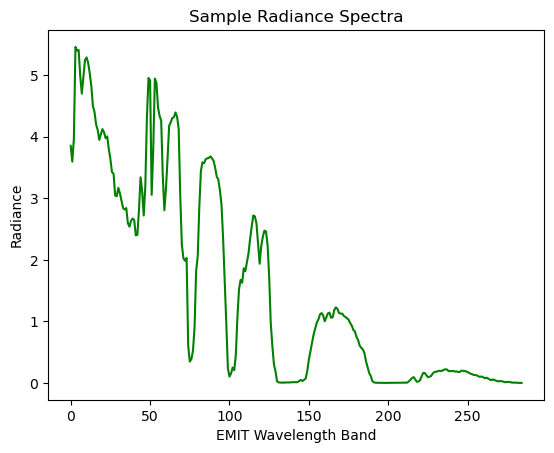

In [31]:
%matplotlib inline
plt.plot(dat_rad[750, 750, :], 'g')
plt.xlabel('EMIT Wavelength Band')
plt.ylabel('Radiance')
plt.title('Sample Radiance Spectra')
plt.show()

In [15]:
zen[1]

0.8104502729097247

In [16]:
rho = (np.pi / np.cos(zen[1])) * dat_rad / irr[np.newaxis, np.newaxis, :] # look into broadcasting
# pi: steradian conversion (hemispherical integration)
# zenith: affects photon flux

# multiply irradiance by (reference earth-sun distance/ observed earth-sun distance) ** 2
rho.shape

(1280, 1242, 285)

In [17]:
plt.plot(rho[750,750,:])
plt.show()

In [4]:
wl[60]

827.746

In [6]:
wl[100]

1126.1964

In [7]:
wl[60:100]

array([ 827.746  ,  835.2074 ,  842.66986,  850.1313 ,  857.5937 ,
        865.0551 ,  872.5176 ,  879.98004,  887.44147,  894.90393,
        902.3664 ,  909.82886,  917.2913 ,  924.7538 ,  932.21625,
        939.6788 ,  947.14026,  954.6027 ,  962.0643 ,  969.5268 ,
        976.9883 ,  984.4498 ,  991.9114 ,  999.37286, 1006.8344 ,
       1014.295  , 1021.7566 , 1029.2172 , 1036.6777 , 1044.1383 ,
       1051.5989 , 1059.0596 , 1066.5201 , 1073.9797 , 1081.4404 ,
       1088.9    , 1096.3597 , 1103.8184 , 1111.2781 , 1118.7368 ])

In [22]:
data = np.load('../../irr.npy')
irr_wl = data[:,0]
irr = data[:,1]

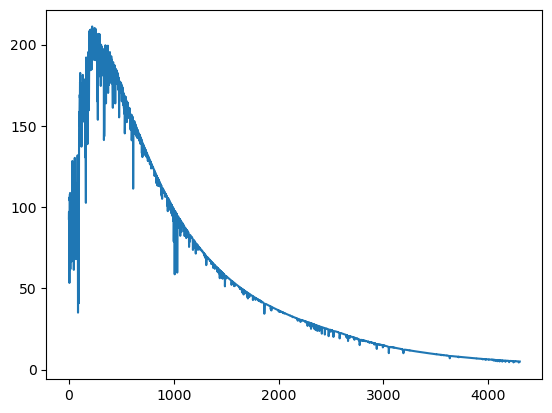

In [24]:
plt.plot(irr)

Text(0.5, 1.0, 'Irradiance')

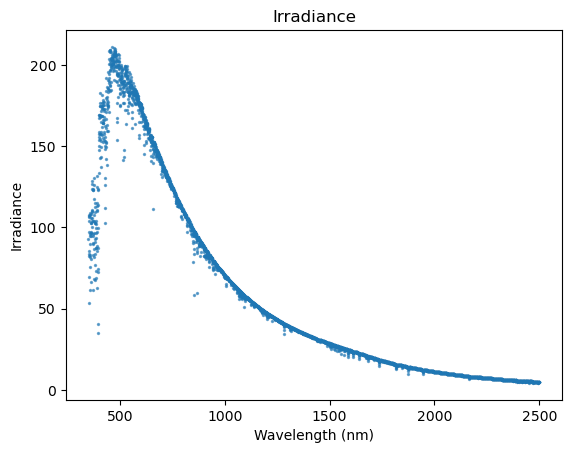

In [33]:
plt.scatter(irr_wl, irr, s = 2, alpha = 0.6)
plt.ylabel('Irradiance')
plt.xlabel('Wavelength (nm)')
plt.title('Irradiance')